In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import os

In [3]:
df_orig = pd.read_csv(r"C:\Users\Pier\Documents\GitHub\Heart-Failure-ML\heart_failure_clinical_records_dataset.csv")

In [5]:
df_orig.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [4]:
df_cleaned = df_orig.drop(["time"],axis=1) # COMO TIME ES MUY DETERMINANTE LA SACAMOS

In [5]:
props_binarias = ["anaemia","diabetes","high_blood_pressure","sex","smoking","DEATH_EVENT"]
props_continuas = ["age","creatinine_phosphokinase","ejection_fraction","platelets","serum_creatinine","serum_sodium"]

### STANDARIZATION VIA Z-SCORE

In [6]:
for prop in props_continuas:
    df_cleaned[prop] = (df_cleaned[prop] - df_cleaned[prop].mean())/(df_cleaned[prop].std())

In [50]:
df_normalized = df_cleaned.copy()

## DEJAMOS SOLO LAS FEATURES CON MAS CORRELACION 

In [51]:
df_normalized.drop(["anaemia","diabetes","high_blood_pressure","sex","smoking","creatinine_phosphokinase","platelets"],axis=1,inplace=True) #VER CUALES DEJAR Y CUALES NO

In [53]:
df_normalized.head(2)

,age,ejection_fraction,serum_creatinine,serum_sodium,DEATH_EVENT
0,1.190949,-1.527998,0.489237,-1.501519,1
1,-0.490457,-0.007065,-0.284076,-0.141739,1


## TENGO LA DATA LIMPIA Y AHORA?

#### TODO ESTO ES UN RESUMEN GUIA, NO SON LOS DATASETS Q VAMOS A USAR

### SEPARO EN TEST Y TRAIN




In [54]:
from sklearn.model_selection import train_test_split

feat_train, feat_test, targ_train, targ_test = train_test_split(df_normalized.drop(["DEATH_EVENT"],axis=1),df_normalized["DEATH_EVENT"],test_size=0.2)

# REGRESION LINEAL

In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

grado = 1

modelo = Pipeline([["poly",PolynomialFeatures(degree=grado,include_bias=True)],["regressor",LinearRegression(fit_intercept=False)]])

modelo.fit(feat_train,targ_train)


Pipeline(steps=[('poly', PolynomialFeatures(degree=1)),
                ['regressor', LinearRegression(fit_intercept=False)]])

In [ ]:
modelo["regressor"].coef_

In [59]:
from sklearn.metrics import mean_squared_error as mse

np.sqrt(mse(targ_test,modelo.predict(feat_test)))

0.3743389714724081

In [ ]:
from sklearn.model_selection import GridSearchCV

hyperparam = {"features__degree":[n for n in range(1,6)]}
#CUANDO HAGO GRILLA PONGO FEATURES
modelo = Pipeline([["features",PolynomialFeatures(degree=grado,include_bias=True)],["regressor",LinearRegression(fit_intercept=False)]])
grilla = GridSearchCV(modelo,hyperparam,refit=True,cv=len(feat_train),scoring="neg_mean_squared_error",verbose=True,n_jobs=-1)
grilla.fit(feat_train,targ_train)


In [ ]:
print(grilla.best_params_)

In [ ]:
for ni, i in enumerate(grilla.cv_results_['params']):
  print(i['features__degree'],-grilla.cv_results_['mean_test_score'][ni])
plt.errorbar(grilla.cv_results_['param_features__degree'].data,np.sqrt(-grilla.cv_results_['mean_test_score']),yerr=grilla.cv_results_['std_test_score'])
plt.yscale('log')
plt.xlabel('grado')
plt.ylabel('RMSE en validacion')

In [ ]:
besthyper_model = grilla.best_estimator_

np.sqrt(mse(targ_test,besthyper_model.predict(feat_test)))

# PRUEBA REGRESION LOGISTICA

In [55]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_curve, auc, roc_auc_score, plot_precision_recall_curve
from sklearn.metrics import plot_roc_curve, roc_curve

In [56]:
from sklearn.model_selection import GridSearchCV

hyperparam = {"poly__degree":[n for n in range(1,14)]}

modelo = Pipeline([["poly",PolynomialFeatures(degree=1,include_bias=True)],["regressor",LogisticRegression(fit_intercept=False, tol=0.0000001, penalty="l2",max_iter=5000)]])

grilla = GridSearchCV(modelo,hyperparam,refit=True,cv=100,scoring="f1",verbose=1,n_jobs=-1)

grilla.fit(feat_train,targ_train)

Fitting 100 folds for each of 13 candidates, totalling 1300 fits


C:\Users\Pier\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 74 members, which is less than n_splits=100.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Pier\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


GridSearchCV(cv=100,
             estimator=Pipeline(steps=[['poly', PolynomialFeatures(degree=1)],
                                       ['regressor',
                                        LogisticRegression(fit_intercept=False,
                                                           max_iter=5000,
                                                           tol=1e-07)]]),
             n_jobs=-1,
             param_grid={'poly__degree': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                          13]},
             scoring='f1', verbose=1)

In [57]:
print(grilla.best_params_)

{'poly__degree': 13}


In [58]:
print(grilla.best_score_)

0.3783333333333333


0.7833333333333333


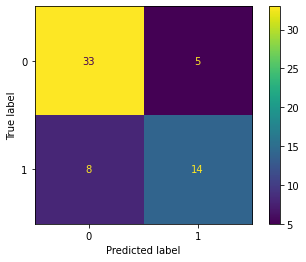

In [59]:
modelo = grilla.best_estimator_


print(accuracy_score(targ_test, modelo.predict(feat_test)))
cm = confusion_matrix(targ_test, modelo.predict(feat_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [ ]:
modelo.predict_proba(feat_test)

In [64]:
print(accuracy_score(targ_test, modelo.predict(feat_test)))

0.7833333333333333


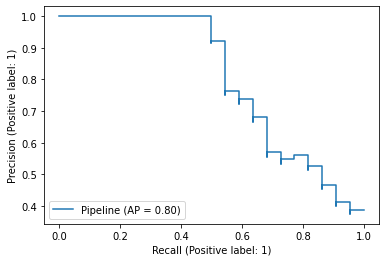

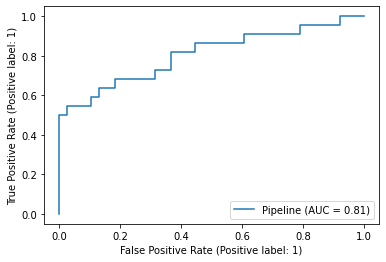

In [69]:
plot_precision_recall_curve(modelo, feat_test, targ_test)
plot_roc_curve(modelo, feat_test, targ_test)